# Table of Contents

- Setup 
    - Dataset and DataLoader
    - Training loop
    - Model architecture
- Model Training
- Model Testing
- General CNN Notes

## Setup

In [1]:
import torch
from torch import tensor, Tensor
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'{device.type = }')

device.type = 'cpu'


### Dataset and DataLoader

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

cifar = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
cifar_loader = DataLoader(dataset=cifar, batch_size=64, shuffle=True)

Files already downloaded and verified


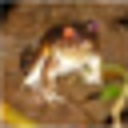

ex_label_idx = 6, idx_to_label[ex_label_idx] = 'frog' 

ex_img.shape = torch.Size([3, 32, 32])
ex_img.numel() = 3072


In [4]:
def display_tensor_as_image(tensor: Tensor):
    '''
    Display a tensor of shape (3, 32, 32) as a (3, 32, 32) image.
    '''
    tensor = tensor.view(3, 32, 32)

    to_img = transforms.ToPILImage()
    img: Image.Image = to_img(tensor)

    img = img.resize((32*4, 32*4))
    display(img)


idx_to_label = {
    idx: label
    for label, idx
    in cifar.class_to_idx.items()
}

ex_img, ex_label_idx = cifar[0]
display_tensor_as_image(ex_img)
print(f'{ex_label_idx = }, {idx_to_label[ex_label_idx] = }', '\n')
print(f'{ex_img.shape = }')
print(f'{ex_img.numel() = }')

### Training Loop

In [5]:
from typing import Callable

def train_one_epoch(model: nn.Module, dataloader: DataLoader, loss_fn: Callable[[Tensor, Tensor], Tensor], optimizer: torch.optim.Optimizer) -> float:
    epoch_running_loss = 0

    for batch in dataloader:
        inputs, labels = batch

        inputs = inputs.to(device) #  move to GPU if available
        labels = labels.to(device) #  move to GPU if available

        optimizer.zero_grad() # zero gradients

        predictions = model(inputs)

        # compute loss and propogate gradients
        loss = loss_fn(predictions, labels)
        loss.backward()

        optimizer.step()

        # update metainformation
        epoch_running_loss += loss.item()

    epoch_avg_loss = epoch_running_loss / len(dataloader)
    return epoch_avg_loss


def train_n_epochs(n: int, model: nn.Module, dataloader: DataLoader, loss_fn: Callable[[Tensor, Tensor], Tensor], optimizer: torch.optim.Optimizer) -> None:
    for i in range(n):
        epoch_avg_loss = train_one_epoch(model, dataloader, loss_fn, optimizer)
        print(f'epoch {i}: {epoch_avg_loss = }')

### Model Architecture

In [6]:
class CNN(nn.Module):
    '''
    Convolutional Neural Network
    '''
    def __init__(self):
        super(CNN, self).__init__()
        in_channels = 3 # rgb image
        original_image_size = 32
        
        conv_1_n_kernels = 10
        conv_1_kernel_size = 3
        conv_1_padding = int((conv_1_kernel_size - 1) / 2) # this is the formula to preserve size assuming a stride of 1

        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=conv_1_n_kernels,
                      kernel_size=conv_1_kernel_size,
                      stride=1,
                      padding=conv_1_padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # this downsamples the input by factor of 2
        )

        # conv layer 1 has about 30,720 parameters: (3 * 32 * 32) * 10

        fully_connected_1_in = int(original_image_size /  2) ** 2 # account for downsample
        fully_connected_1_out = 100
        self.fully_connected_1 = nn.Sequential(
            nn.Linear(fully_connected_1_in * conv_1_n_kernels, fully_connected_1_out),
            nn.ReLU()
        )

        self.fully_connected_2 = nn.Sequential(
            nn.Linear(fully_connected_1_out, 10),
        )

    def forward(self, x):
        x = self.conv_1(x)
        x = x.flatten(start_dim=1) # [batch_size, width, height] => [batch_size, width*height]
        x = self.fully_connected_1(x)
        x = self.fully_connected_2(x)
        return x

---
## Model Training

In [9]:
cnn = CNN()
cnn.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lr=.001, params=cnn.parameters())

This model has already trained for 40 epochs (20 + 10 + 10)

In [16]:
n_epochs = 10 
train_n_epochs(n_epochs, cnn, cifar_loader, loss_fn, optimizer)

epoch 0: epoch_avg_loss = 0.4290241615279861
epoch 1: epoch_avg_loss = 0.4101133056347023
epoch 2: epoch_avg_loss = 0.39340878731530643
epoch 3: epoch_avg_loss = 0.3825395021330365
epoch 4: epoch_avg_loss = 0.36798539449034445
epoch 5: epoch_avg_loss = 0.35850755237709836
epoch 6: epoch_avg_loss = 0.3437392112163022
epoch 7: epoch_avg_loss = 0.3315314308209035
epoch 8: epoch_avg_loss = 0.3203093975953891
epoch 9: epoch_avg_loss = 0.30704234016444676


---
## Model Testing

In [12]:
cifar_test = datasets.CIFAR10('./data', train=False, download=True, transform=transform)
cifar_test_loader = DataLoader(dataset=cifar_test, batch_size=64, shuffle=True)

Files already downloaded and verified


In [17]:
cnn.eval()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in cifar_test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = cnn(inputs)

        _, predictions = torch.max(logits, 1)

        # predictions.shape = [64]
        # labels.shape = [64]

        total += len(inputs)
        correct += (predictions == labels).sum().item()

accuracy = correct / total
print(f'Accuracy of the cnn on the MNIST test images: {accuracy * 100}%')

Accuracy of the cnn on the MNIST test images: 57.93000000000001%


### First Model - Baseline
```python
CNN(
  (conv_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected_1): Sequential(
    (0): Linear(in_features=2560, out_features=100, bias=True)
    (1): ReLU()
  )
  (fully_connected_2): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
  )
)

# num parameters
sum(p.numel() for p in cnn.parameters() if p.requires_grad) # => 257390 parameters
```

- after 20 epcohs: 61.08% accuracy
- after 30 epochs: 58.81% accuracy
- after 40 epochs: 57.93% accuracy

it is obviously overfitting.

---

## General CNN Notes

### What is the kernel doing with 3 channels?

In [9]:
torch.manual_seed(3)

kernel = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, padding=1, stride=1)
print(f'{kernel.weight.shape = }', '\n')

input_data = torch.ones(3, 5, 5)
print(f'{input_data.shape = }', '\n')

kernel.weight.shape = torch.Size([1, 3, 3, 3]) 

input_data.shape = torch.Size([3, 5, 5]) 



In [12]:
feature_map = kernel(input_data)
print(f'{feature_map.shape = }')

feature_map.shape = torch.Size([1, 5, 5])


In [31]:
feature_map_top_left_value = feature_map[0][0][0]
feature_map_top_left_value

tensor(-0.3880, grad_fn=<SelectBackward0>)

-0.3880 is the actual output value at the top left of the feature map (aka the value from the top left corner of the input data). I want to calculate this manually to verify the calculation works like I expect 

In [66]:
import torch.nn.functional as F

first_chunk_of_input = input_data[:, :2, :2]

# pad tuple: (left, right, top, bottom)
first_chunk_of_input = F.pad(first_chunk_of_input, (1, 0, 1, 0), 'constant', 0)

first_chunk_of_input, first_chunk_of_input.shape

(tensor([[[0., 0., 0.],
          [0., 1., 1.],
          [0., 1., 1.]],
 
         [[0., 0., 0.],
          [0., 1., 1.],
          [0., 1., 1.]],
 
         [[0., 0., 0.],
          [0., 1., 1.],
          [0., 1., 1.]]]),
 torch.Size([3, 3, 3]))

#### Thinking of the problem with dot products

This is an alternative view point (compared to element wise multiplication and then sums), which gives better insight into the fact that the kernel is capturing the similarity between the channels of the input data and the kernel's layers. The convolution operation is a channel wise operation of computing dot products with a sliding window.

In [65]:
num_channels = 3
kernel_layer_outputs = [torch.dot(kernel.weight[0][i].flatten(), first_chunk_of_input[i].flatten()) for i in range(num_channels)]
sum(kernel_layer_outputs) + kernel.bias

tensor([-0.3880], grad_fn=<AddBackward0>)